In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2023/05/02
# @Author  : D_Chameleon
# @File    : DEMO_network.ipynb
# @Software: PyCharm & Visual Studio Code
#########################################################
import scipy.io as scio
import numpy as np
from sklearn.model_selection import *
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
##########################################################

In [2]:
feature = scio.loadmat('./Data/BufferFeatures.mat')
acc = scio.loadmat('./Data/BufferedAccelerations.mat')
feat = feature['feat']
actnames = acc['actnames']
actid = acc['actid']
atx = acc['atx']
aty = acc['aty']
atz = acc['atz']

actid_label = actid.reshape(1, -1)[0]-1

feature_size = np.shape(feat)[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
feat_minmax = scaler_minmax.fit_transform(feat)

训练集与测试集构建

In [3]:
feat_train, feat_test, actid_train, actid_test = \
    train_test_split(feat_minmax, actid_label, test_size=0.5)
feat_train = torch.from_numpy(feat_train).to(torch.float).to(device)
feat_test = torch.from_numpy(feat_test).to(torch.float).to(device)
actid_train = torch.from_numpy(actid_train).to(torch.int64).to(device)
actid_test = torch.from_numpy(actid_test).to(torch.int64).to(device)

batch_size = 30
train_dataset = TensorDataset(feat_train, actid_train)
test_dataset = TensorDataset(feat_test, actid_test)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

模型构建

In [4]:
num_inputs, num_outputs, num_hiddens= feature_size, 6, 100
net = nn.Sequential(
    nn.Linear(num_inputs, num_hiddens),
    # nn.Sigmoid(),
    # nn.Linear(num_hiddens, num_hiddens),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(num_hiddens, num_outputs)
    # torch交叉熵的损失函数自带softmax运算，这里就没有再加一层激活函数
    ).to(device)


参数初始化

In [5]:
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.005)


def acc(test_iter, net, device):
    acc_sum, n = 0.0, 0
    for x, y in test_iter:
        acc_sum += (net(x.to(device)).argmax(dim=1) == y.to(device)).sum().item()
        n += y.shape[0]
    return acc_sum / n


K = acc(test_iter, net, device)
print(K)

0.14854368932038836


交叉熵损失函数

In [6]:
loss = torch.nn.CrossEntropyLoss()

优化器

In [7]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.02, weight_decay=0.0001)

训练与可视化输出

epoch 1, loss 1.7857, train acc 0.193, test acc 0.189
epoch 2, loss 1.7099, train acc 0.206, test acc 0.264
epoch 3, loss 1.4762, train acc 0.380, test acc 0.491
epoch 4, loss 1.1849, train acc 0.519, test acc 0.555
epoch 5, loss 0.9986, train acc 0.567, test acc 0.588
epoch 6, loss 0.8986, train acc 0.602, test acc 0.615
epoch 7, loss 0.8451, train acc 0.616, test acc 0.639
epoch 8, loss 0.8025, train acc 0.634, test acc 0.661
epoch 9, loss 0.7646, train acc 0.656, test acc 0.657
epoch 10, loss 0.7387, train acc 0.674, test acc 0.683
epoch 11, loss 0.7060, train acc 0.687, test acc 0.689
epoch 12, loss 0.6821, train acc 0.695, test acc 0.705
epoch 13, loss 0.6532, train acc 0.720, test acc 0.699
epoch 14, loss 0.6202, train acc 0.737, test acc 0.722
epoch 15, loss 0.5975, train acc 0.751, test acc 0.732
epoch 16, loss 0.5751, train acc 0.760, test acc 0.757
epoch 17, loss 0.5500, train acc 0.770, test acc 0.781
epoch 18, loss 0.5253, train acc 0.786, test acc 0.770
epoch 19, loss 0.51

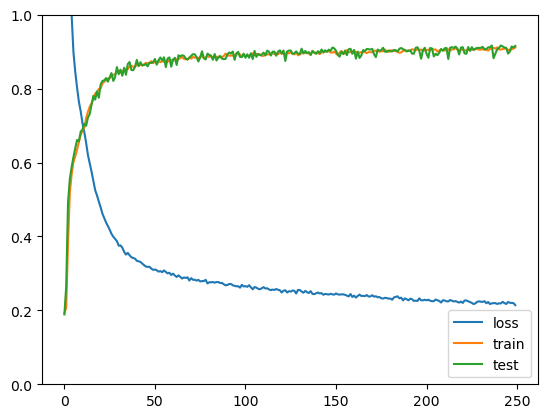

In [8]:
train_allacc = []
test_allacc = []
loss_all = []
num_epochs = 250
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for x, y in train_iter:
        y_hat = net(x)
        lo = loss(y_hat, y).sum()
        optimizer.zero_grad()  # 优化器的梯度清零
        lo.backward()  # 反向传播梯度计算
        optimizer.step()  # 优化器迭代
        train_l_sum += lo.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = acc(test_iter, net, device)
    train_allacc.append(train_acc_sum / n)
    test_allacc.append(test_acc)
    loss_all.append(batch_size * train_l_sum / n)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch + 1, batch_size * train_l_sum / n, train_acc_sum / n, test_acc))
plt.plot(loss_all, label='loss')
plt.plot(train_allacc, label='train')
plt.plot(test_allacc, label='test')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()
